# Execute prediction

## Imports

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
from typing import List, Optional, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import wilcoxon

from matplotlib.colors import ListedColormap

import lightning as L
import torch
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
import pytorch_lightning as pl
from torchinfo import summary

from minerva.models.finetune_adapters import LoRA
from minerva.models.nets.image.sam import Sam
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline

from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from lightning.pytorch.loggers import CSVLogger

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


## Variables

In [3]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# parihaka
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoints SAM
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth" # vit_b
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_h_4b8939.pth" # vit_h

model_name = "SAM-ViT_B"
vit_model = 'vit-b'
height, width = 255, 701 # f3
# height, width = 1006, 590 # parihaka
multimask_output=True
num_classes = 6

ratio = 0.01 # if 1.0, will use checkpoint treined with 100% of dataset
# ratio = 0.01 # if 0.01, will use checkpoint treined with 1% of dataset
batch_size = 2

# fine_tuning & adapter
if ratio == 1.0:
    # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_adapter_1.0-2024-12-18-epoch=10-val_loss=0.13.ckpt"
    checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-fine_tuning_&_adapter_1.0-2024-12-17-epoch=98-val_loss=0.01.ckpt"
else:
    # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_adapter_0.01-2024-12-18-epoch=79-val_loss=0.33.ckpt"
    checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-fine_tuning_&_adapter_0.01-2024-12-17-epoch=80-val_loss=0.20.ckpt"
model_name_experiment = f"fine_tuning_&_adapter_{ratio}"
apply_freeze={"prompt_encoder": True, "image_encoder": False, "mask_decoder": True}
apply_adapter={"mask_decoder": LoRA}

# # fine_tuning & fine_tuning
# if ratio == 1.0:
#     # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_fine_tuning_1.0-2024-12-18-epoch=04-val_loss=0.09.ckpt"
#     checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-fine_tuning_&_fine_tuning_1.0-2024-12-17-epoch=98-val_loss=0.01.ckpt"
# else:
#     # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_fine_tuning_0.01-2024-12-18-epoch=70-val_loss=0.24.ckpt"
#     checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-fine_tuning_&_fine_tuning_0.01-2024-12-17-epoch=95-val_loss=0.18.ckpt"
# model_name_experiment = f"fine_tuning_&_fine_tuning_{ratio}"
# apply_freeze={"prompt_encoder": True, "image_encoder": False, "mask_decoder": False}
# apply_adapter={}

# # fine_tuning & freeze
# if ratio == 1.0:
#     # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_freeze_1.0-2024-12-18-epoch=10-val_loss=0.12.ckpt"
#     checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-fine_tuning_&_freeze_1.0-2024-12-18-epoch=98-val_loss=0.01.ckpt"
# else:
#     # checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_parihaka/sam-fine_tuning_&_freeze_0.01-2024-12-18-epoch=83-val_loss=0.31.ckpt"
#     checkpoint = "/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints_f3/sam-novo__fine_tuning_&_freeze_0.01-2024-12-19-epoch=99-val_loss=0.20.ckpt"
# model_name_experiment = f"fine_tuning_&_freeze_{ratio}"
# apply_freeze={"prompt_encoder": True, "image_encoder": False, "mask_decoder": True}
# apply_adapter={}

## Transform

In [4]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded

## Custom Dataset

In [5]:
# TODO USAR SÓ QUANDO IMPLEMENTAR O SCRIPT DE PROMPT NAS IMAGENS
class DatasetForSAM(SimpleDataset):
    def __init__(
            self, 
            readers: List[_Reader], 
            transforms: Optional[_Transform] = None,
            transform_coords_input:Optional[dict]=None,
            multimask_output:bool=True,
    ):
        """
        Custom Dataset to use properties that needed in images when send some image to SAM model.

        Parameters
        ----------
        readers: List[_Reader]
            List of data readers. It must contain exactly 2 readers.
            The first reader for the input data and the second reader for the
            target data.
        transforms: Optional[_Transform]
            Optional data transformation pipeline.
        transform_coords_input: Optional[dict] 
            List with transforms to apply.
                point_coords (np.ndarray or None): A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.
                point_labels (np.ndarray or None): A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.
    """
        super().__init__(readers, transforms)
        # self.transform_coords_input = transform_coords_input
        self.multimask_output = multimask_output

        assert (
            len(self.readers) == 2
        ), "DatasetForSAM requires exactly 2 readers (image your label)"

        # assert (
        #     len(self.readers) == len(self.transforms)
        #     and len(self.transforms) == len(self.transform_coords_input)
        #     and len(self.readers) == len(self.transform_coords_input)
        # ), "DatasetForSAM requires exactly iquals lens (readers, transforms and transform_coords_input)"
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Load data and return data with SAM format (dict), where dict has:
        'image' (required): The image as a torch tensor in 3xHxW format.
        'label' (required): The label of the image.
        'original_size' (required): The original size of the image before transformation.
        'point_coords' (optional): (torch.Tensor) Batched point prompts for this image, with shape BxNx2. Already transformed to the input frame of the model.
        'point_labels' (optional): (torch.Tensor) Batched labels for point prompts, with shape BxN. (0 is background, 1 is object and -1 is pad)
        'boxes' (optional): (torch.Tensor) Batched box inputs, with shape Bx4.  Already transformed to the input frame of the model.
        'mask_inputs' (optional): (torch.Tensor) Batched mask inputs to the model, in the form Bx1xHxW.
        """

        data_readers = []
        for reader, transform in zip(self.readers, self.transforms):
            sample = reader[index]
            if transform is not None:
                sample = transform(sample)
            data_readers.append(sample)
        
        data = {}
        # apply transform_coords_input to image (only in the image, not in label)
        # if self.transform_coords_input['point_coords'] is not None: # TODO adicionar essa parte quando implementar treino com prompts
        # image = self.readers[0][index]
        # TODO Implementar algum script que coloque pontos aleatoriamente nas fácies
        # point_coords = self.transform_coords_input['point_coords'].apply_coords(point_coords, self.original_size)
        # coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
        # labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=self.device)
        # coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        
        data['image'] = data_readers[0]
        data['label'] = data_readers[1]
        data['original_size'] = (int(data_readers[0].shape[1]), int(data_readers[0].shape[2])) # (tem que usar o shape depois do transform, se não dá erro) (int(image.shape[0]), int(image.shape[1]))
        data['multimask_output'] = self.multimask_output
        # TODO OBS: Só pode passar esses pontos se aplicar o transform_coords. Se tentar passar como None vai dar erro no Dataloader.
        # data['point_coords'] = None
        # data['point_labels'] = None
        # data['boxes'] = None
        # data['mask_inputs'] = None

        return data # (data, self.multimask_output)

## Datamodule

In [6]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        transform_coords_input: _Transform = None,
        multimask_output:bool = True,
        batch_size: int = 1,
        data_ratio: float = 1.0,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.transform_coords_input = transform_coords_input
        self.multimask_output = multimask_output
        self.batch_size = batch_size
        self.data_ratio = data_ratio
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")

            # applying ratio
            num_train_samples = int(len(train_img_reader) * self.data_ratio)
            if num_train_samples < len(train_img_reader):
                indices = random.sample(range(len(train_img_reader)), num_train_samples)
                train_img_reader = [train_img_reader[i] for i in indices]
                train_label_reader = [train_label_reader[i] for i in indices]
                
            train_dataset = DatasetForSAM(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = DatasetForSAM(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = DatasetForSAM(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")
    
    def custom_collate_fn(self, batch):
        """
        Custom collate function for DataLoader to return a list of dictionaries.
        """
        return batch 

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self.custom_collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

## Execute Predict

In [7]:
data_module = DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=Padding(height, width),
    multimask_output=multimask_output,
    batch_size=batch_size,
    data_ratio=ratio
)

In [8]:
model = Sam.load_from_checkpoint(
    checkpoint_path=checkpoint,
    vit_type=vit_model,
    num_multimask_outputs=num_classes,
    iou_head_depth=num_classes,
    apply_freeze=apply_freeze,
    apply_adapter=apply_adapter,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)}
)

model.eval()

Prompt Encoder freeze!
Mask Decoder freeze!
LoRA applied in Mask Decoder!


Sam(
  (loss_fn): CrossEntropyLoss()
  (model): _SAM(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256,

In [9]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
data_module.setup(stage='predict')  # Configura os dados para inferência
miou_metric = JaccardIndex(task="multiclass", num_classes=num_classes) # Inicializando a métrica de mIoU
predict_dataloader = data_module.predict_dataloader()

In [11]:
def compute_miou_for_each_sample(model, dataloader):
    model.eval()
    miou_scores = []
    image_ids = []
    ious = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            for item in batch:
                item['image'] = item['image'].to(model.device)
                item['label'] = item['label'].to(model.device)

            # Inferência
            outputs = model(batch, multimask_output=multimask_output)
            
            # stack logits 'masks_logits' and 'labels' for loss and metrics function
            masks_logits = torch.stack([output['masks_logits'].squeeze(0) for output in outputs])  # [batch_size, num_classes, H, W]
            labels = torch.stack([input['label'].squeeze(0) for input in batch])  # [batch_size, H, W]

            # (DEBUG)
            # print("masks_logits shape: ", masks_logits.shape)
            # print("labels shape: ", labels.shape)

            # Calcular mIoU para cada imagem individualmente
            for i in range(len(batch)):
                pred = masks_logits[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)

                # (DEBUG)
                # print("antes do argmax:")
                # print(f"masks_logits[{i}] shape: ", pred.shape)
                # print(f"labels[{i}] shape: ", label.shape)
                
                pred = torch.argmax(pred, dim=1, keepdim=True).squeeze(1)

                # calculando iou das classes separadamente
                iou_scores_per_class = []
                for c in range(num_classes):
                    # Máscaras binárias para a classe c
                    pred_c = (pred == c).float()
                    label_c = (label == c).float()
                    # DEBUG
                    if (batch_idx * len(batch) + i) == 199:
                        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                        axes[0].imshow(label_c.cpu().permute(1, 2, 0), cmap='gray')
                        axes[0].axis('off')
                        axes[0].set_title("label_c")
                        axes[1].imshow(pred_c.cpu().permute(1, 2, 0), cmap='gray')
                        axes[1].axis('off')
                        axes[1].set_title("pred_c")
                        plt.tight_layout()
                        plt.show()

                    # Calcula a interseção e a união
                    intersection = (pred_c * label_c).sum()  # Pixels em comum
                    union = (pred_c + label_c).clamp(0, 1).sum()  # Soma das máscaras binárias

                    # Evita divisão por zero
                    iou = (intersection / union).item() if union > 0 else 0.0
                    iou_scores_per_class.append(iou)
                ious.append(iou_scores_per_class)

                # (DEBUG)
                # print("depois do argmax:")
                # print(f"masks_logits[{i}] shape: ", pred.shape)
                # print(f"labels[{i}] shape: ", label.shape)

                # Calcular o mIoU para a imagem i
                metric = miou_metric.to(model.device)(pred, label)
                # print(f"metric for image {i}: ", metric.item())
                miou_scores.append(metric.item())
                image_ids.append(batch_idx * len(batch) + i)
                
                # (DEBUG) visualizar as imagens
                # pred = pred.squeeze(0).cpu().detach().numpy()  # Converte para numpy para plotar
                # label = label.squeeze(0).cpu().detach().numpy()  # Converte para numpy para plotar
                # fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Cria 2 colunas
                # axs[0].imshow(pred, cmap='gray')          # Exibe a máscara
                # axs[0].set_title("Mask Logits")           # Título para a primeira imagem
                # axs[0].axis('off')                       # Remove os eixos da imagem
                # axs[1].imshow(label, cmap='gray')        # Exibe os labels
                # axs[1].set_title("Labels")               # Título para a segunda imagem
                # axs[1].axis('off')                       # Remove os eixos da imagem
                # plt.tight_layout()
                # plt.show()

    return image_ids, miou_scores, ious

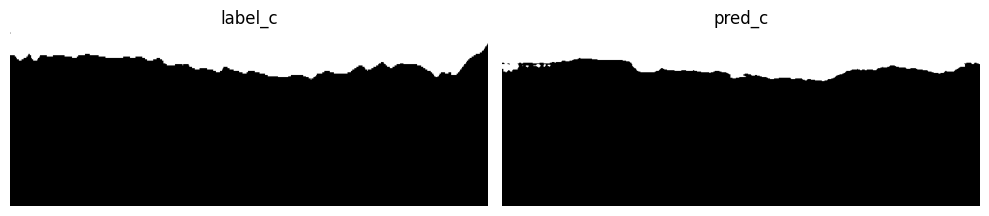

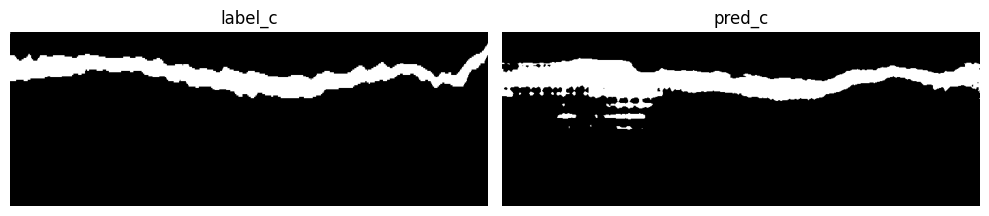

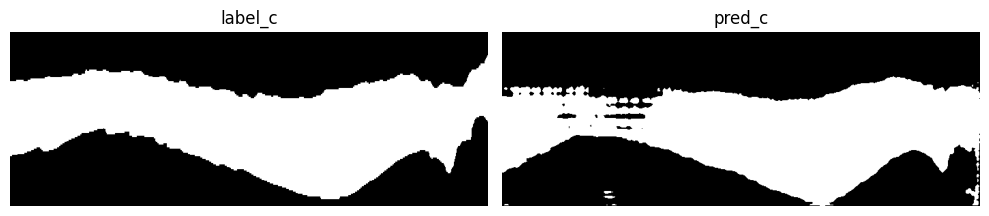

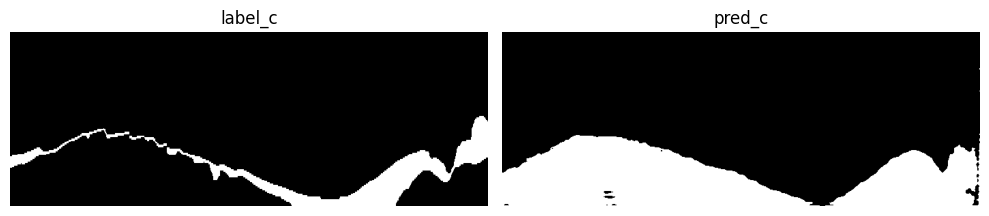

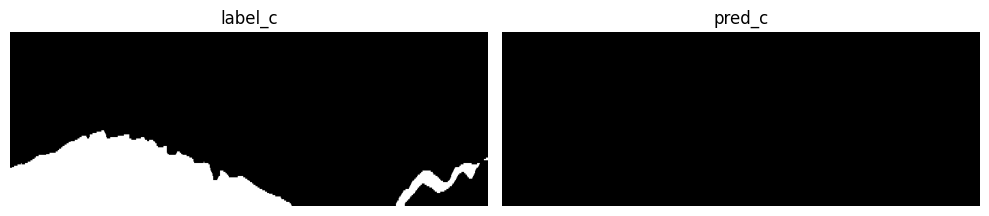

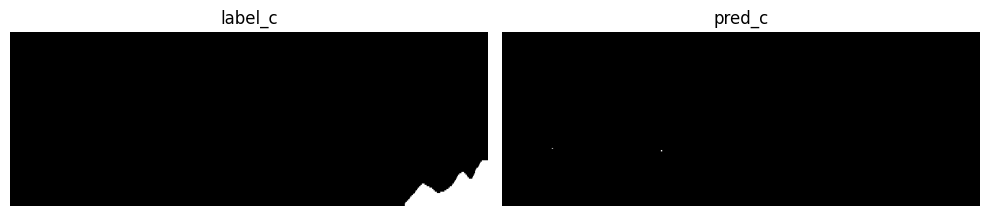

Resultados salvos no arquivo fine_tuning_&_adapter_0.01_miou_results.csv
mIoU for image 0: 0.35967808961868286 -> [0.8291248083114624, 0.3885710537433624, 0.6921093463897705, 0.24826335906982422, 0.0, 0.0]
mIoU for image 1: 0.3495538830757141 -> [0.8197940587997437, 0.3535277247428894, 0.6821960210800171, 0.24180558323860168, 0.0, 0.0]
mIoU for image 2: 0.3600116968154907 -> [0.8344708681106567, 0.35685887932777405, 0.7083655595779419, 0.2603748142719269, 0.0, 0.0]
mIoU for image 3: 0.39929819107055664 -> [0.887702465057373, 0.49180808663368225, 0.8289439082145691, 0.18733464181423187, 0.0, 0.0]
mIoU for image 4: 0.4075711965560913 -> [0.8933923840522766, 0.5210286378860474, 0.8415660262107849, 0.18943998217582703, 0.0, 0.0]
mIoU for image 5: 0.407284677028656 -> [0.8916736245155334, 0.524756669998169, 0.8418043255805969, 0.18547332286834717, 0.0, 0.0]
mIoU for image 6: 0.40779638290405273 -> [0.8907582759857178, 0.5325466990470886, 0.841054379940033, 0.1824188381433487, 0.0, 0.0]
mIoU

In [12]:
# Calcular o mIoU para cada amostra no conjunto de dados de inferência
image_ids, miou_scores, ious = compute_miou_for_each_sample(model, predict_dataloader)

# Expandir os valores de IoU para colunas separadas
ious_expanded = pd.DataFrame(ious, columns=[f'facie {i}' for i in range(len(ious[0]))])

# Criar um DataFrame com pandas combinando tudo
df = pd.DataFrame({
    'Image ID': image_ids,
    'mIoU': miou_scores
})

# Concatenar as colunas de IoU ao DataFrame principal
df = pd.concat([df, ious_expanded], axis=1)

# Salvar o DataFrame em um arquivo CSV
df.to_csv(f'{model_name_experiment}_miou_results.csv', index=False)

print(f"Resultados salvos no arquivo {model_name_experiment}_miou_results.csv")

# Exibir os mIoUs por amostra
for image_id, miou, iou in zip(image_ids, miou_scores, ious):
    print(f"mIoU for image {image_id}: {miou} -> {iou}")

# Calculate iou per class

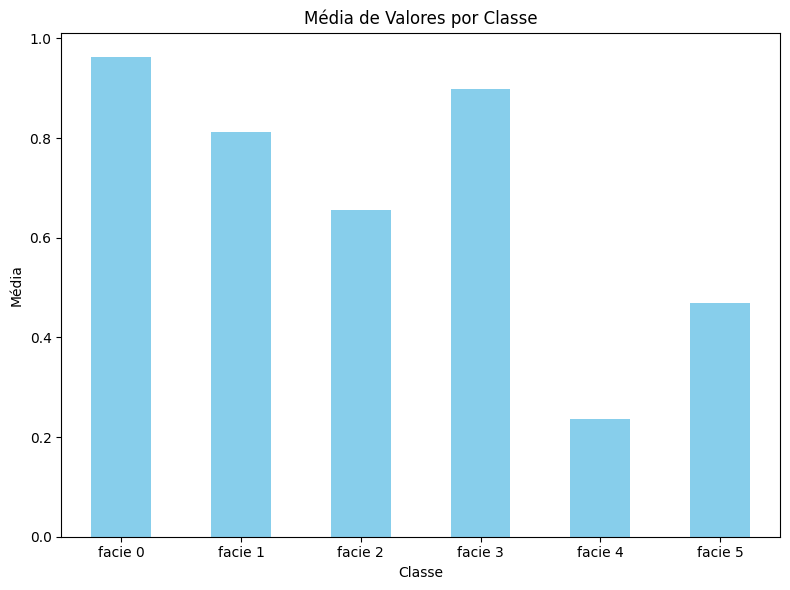

Média de mIoU: 0.6727


In [ ]:
# Carregar o CSV
df = pd.read_csv('parihaka_fine_tuning_&_adapter_1.0_miou_results.csv')

# Calcular a média para cada classe (class_0, class_1, ..., class_5)
class_columns = ['facie 0', 'facie 1', 'facie 2', 'facie 3', 'facie 4', 'facie 5']
mean_values = df[class_columns].mean()

# Plotar o gráfico de colunas
plt.figure(figsize=(8, 6))
mean_values.plot(kind='bar', color='skyblue')

# Adicionar título e rótulos
plt.title('Média de Valores por Classe')
plt.xlabel('Classe')
plt.ylabel('Média')
plt.xticks(rotation=0)  # Para deixar as classes legíveis no eixo X

# Mostrar o gráfico
plt.tight_layout()
plt.show()

miou = mean_values.mean()

# Exibir o mIoU
print(f'Média de mIoU: {miou:.4f}')

# Calcute Wilcoxon Test

# parihaka:
- mean:
    - 1%:
        - fine_tuning_&_adapter_0.01 = 0.5096414126455784
        - fine_tuning_&_fine_tuning_0.01: 0.5383737888932228
        - fine_tuning_&_freeze_0.01: 0.5063718400895596
    - 100%:
        - fine_tuning_&_adapter_1.0 = 0.6726830811798572
        - fine_tuning_&_fine_tuning_1.0: 0.6761178289353847
        - fine_tuning_&_freeze_1.0: 0.6581141336262226

- wilcoxon test:
    - 1%:
        - fine_tuning_&_adapter vs fine_tuning_&_fine_tuning:
            - Estatística do teste de Wilcoxon: 5400.0
            - Valor-p: 1.3967123589612272e-08
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_adapter vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 8545.0
            - Valor-p: 0.06630500401841917
            - Não há diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_fine_tuning vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 5634.0
            - Valor-p: 7.113852130985211e-08
            - Há uma diferença estatisticamente significativa entre os dois modelos.
    - 100%:
        - fine_tuning_&_adapter vs fine_tuning_&_fine_tuning:
            - Estatística do teste de Wilcoxon: 8230.0
            - Valor-p: 0.026370627801828344
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_adapter vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 2157.0
            - Valor-p: 5.926437268707572e-22
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_fine_tuning vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 3705.0
            - Valor-p: 9.788053527431182e-15
            - Há uma diferença estatisticamente significativa entre os dois modelos.

## f3:
- mean:
    - 1%:
        - fine_tuning_&_adapter_0.01 = 0.43680451937019826
        - fine_tuning_&_fine_tuning_0.01: 0.4427109777182341
        - fine_tuning_&_freeze_0.01: 0.274414798989892
    - 100%:
        - fine_tuning_&_adapter_1.0 = 0.6900265274941921
        - fine_tuning_&_fine_tuning_1.0: 0.6096016861498356
        - fine_tuning_&_freeze_1.0: 0.6787577167153358

- wilcoxon test:
    - 1%:
        - fine_tuning_&_adapter vs fine_tuning_&_fine_tuning:
            - Estatística do teste de Wilcoxon: 29618.0
            - Valor-p: 5.888727022565262e-06
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_adapter vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 3.0
            - Valor-p: 2.7923188362518613e-67
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_fine_tuning vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 0.0
            - Valor-p: 2.73006926195335e-67
            - Há uma diferença estatisticamente significativa entre os dois modelos.
    - 100%:
        - fine_tuning_&_adapter vs fine_tuning_&_fine_tuning:
            - Estatística do teste de Wilcoxon: 2121.0
            - Valor-p: 1.5033086177710576e-60
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_adapter vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 33027.0
            - Valor-p: 0.0022358842584386603
            - Há uma diferença estatisticamente significativa entre os dois modelos.
        - fine_tuning_&_fine_tuning vs fine_tuning_&_freeze:
            - Estatística do teste de Wilcoxon: 4139.0
            - Valor-p: 1.790608562744406e-54
            - Há uma diferença estatisticamente significativa entre os dois modelos.

In [14]:
df = pd.read_csv('/workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/fine_tuning_&_freeze_0.01_miou_results.csv')

# Calcular a média da coluna 'miou'
media_miou = df['mIoU'].mean()

print(f'A média da coluna miou é: {media_miou}')

A média da coluna miou é: 0.45442340679466725


In [19]:
df_modelA = pd.read_csv('fine_tuning_&_fine_tuning_0.01_miou_results.csv')
df_modelB = pd.read_csv('fine_tuning_&_freeze_0.01_miou_results.csv')

mIoU_modeloA = df_modelA['mIoU']
mIoU_modeloB = df_modelB['mIoU']

stat, p_value = wilcoxon(mIoU_modeloA, mIoU_modeloB)

print(f"Estatística do teste de Wilcoxon: {stat}")
print(f"Valor-p: {p_value}")

# 5. Interpretação do valor-p
if p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os dois modelos.")
else:
    print("Não há diferença estatisticamente significativa entre os dois modelos.")

Estatística do teste de Wilcoxon: 36878.0
Valor-p: 0.16375404964641715
Não há diferença estatisticamente significativa entre os dois modelos.
